In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df = pd.read_csv('./combined_wtcd.csv')
df

,rating,combined,action,comic,daily,drama,fantasy,historical,pure,sensibility,sports,thrill,story,episode,omnibus
0,9.30,예수 다이어리 기독교 세상 제일 날 예수 안티 크리스천 예수 일상 토요일 업데이트,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0
1,9.89,애 하숙집 꼬마 하숙 생,0,1,1,0,0,0,0,0,0,0,0.0,0.0,1.0
2,9.85,섭식장애 일기 섭식장애,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0
3,9.77,오늘 후기 여러분 오늘 무슨 매일 김 그림 일기 오늘 후기 자유 연재,0,1,1,0,0,0,0,0,0,0,0.0,1.0,0.0
4,9.73,제제 출산 육아 처음 초보 맘 첫째 아들 둘째 딸 출산 첫째 아이 자폐 진단 연년생...,0,0,1,1,0,0,0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,9.59,혈 고교 농구 리그,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0
3188,9.79,모두 추억 월드컵 그날 감동 다시 한번,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0
3189,9.79,공 각기 다른 문제 제자리 네 명의 청춘 길거리 농구대회 우승 목표 가지 전국 여행,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0
3190,9.83,샌프란시스코 화랑 관 샌프란시스코 화랑 관 태권도 한국인 가야,0,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0


In [3]:
# Tokenize the 'combined' column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['combined'])

In [4]:
# Remove rare words
counts = tokenizer.word_counts
num_rare_words = len([word for word, count in counts.items() if count < 2])
tokenizer.num_words = len(counts) - num_rare_words

In [5]:
# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['combined'])
# Pad sequences
max_length = max(len(sequence) for sequence in sequences)
X_text = pad_sequences(sequences, maxlen=max_length)

In [6]:
# Get the one-hot encoded columns
X_one_hot = df.drop(columns=['combined', 'rating']).values
X = np.concatenate([X_text, X_one_hot], axis=1)
y = df['rating'].values

In [7]:
# Split the sequence data into training and testing sets
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2)

# Split the one-hot-encoded data into training and testing sets
X_one_hot_train, X_one_hot_test, _, _ = train_test_split(X_one_hot, y, test_size=0.2)

In [15]:
from keras.layers import Input, concatenate, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError

inputA = Input(shape=(max_length,))
inputB = Input(shape=(df.drop(columns=['combined', 'rating']).shape[1],))

# The first branch
x = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(inputA)
x = LSTM(256, dropout=0.2, recurrent_dropout=0.2)(x)
x = Model(inputs=inputA, outputs=x)

# The second branch
y = Dense(128, activation="relu")(inputB)
y = Dropout(0.2)(y)
y = Dense(64, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

# Combine and create the final model
combined = concatenate([x.output, y.output])
z = Dense(1, activation="linear")(combined)
model = Model(inputs=[x.input, y.input], outputs=z)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[MeanSquaredError(name='mse'), 
                       RootMeanSquaredError(name='rmse'), 
                       MeanAbsoluteError(name='mae')])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [16]:
history = model.fit(
    [X_text_train, X_one_hot_train], y_train,
    validation_data=([X_text_test, X_one_hot_test], y_test),
    epochs=10, callbacks=[early_stopping]
)

Epoch 1/10


80/80 [==============================] - 21s 223ms/step - loss: 6.3167 - mse: 6.3167 - rmse: 2.5133 - mae: 1.0831 - val_loss: 0.1284 - val_mse: 0.1284 - val_rmse: 0.3583 - val_mae: 0.2266
Epoch 2/10
80/80 [==============================] - 18s 221ms/step - loss: 0.1705 - mse: 0.1705 - rmse: 0.4129 - mae: 0.2679 - val_loss: 0.1263 - val_mse: 0.1263 - val_rmse: 0.3554 - val_mae: 0.2533
Epoch 3/10
80/80 [==============================] - 18s 223ms/step - loss: 0.1575 - mse: 0.1575 - rmse: 0.3968 - mae: 0.2520 - val_loss: 0.1290 - val_mse: 0.1290 - val_rmse: 0.3592 - val_mae: 0.2645
Epoch 4/10
80/80 [==============================] - 18s 229ms/step - loss: 0.1437 - mse: 0.1437 - rmse: 0.3791 - mae: 0.2431 - val_loss: 0.1285 - val_mse: 0.1285 - val_rmse: 0.3585 - val_mae: 0.2411
Epoch 5/10
80/80 [==============================] - 19s 232ms/step - loss: 0.1395 - mse: 0.1395 - rmse: 0.3735 - mae: 0.2367 - val_loss: 0.1610 - val_mse: 0.1610 - val_rmse: 0.4013 - val_mae: 0.3152


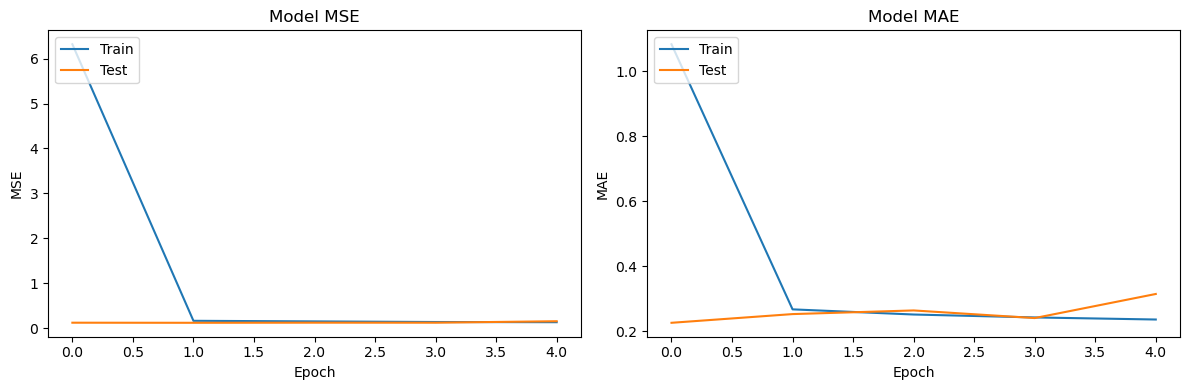

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
from keras.layers import Input, Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping

inputA = Input(shape=(max_length,))
inputB = Input(shape=(df.drop(columns=['combined', 'rating']).shape[1],))

# The first branch
x = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(inputA)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Model(inputs=inputA, outputs=x)

# The second branch
y = Dense(128, activation="relu")(inputB)
y = Dropout(0.2)(y)
y = Dense(64, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

# Combine and create the final model
combined = concatenate([x.output, y.output])
z = Dense(1, activation="linear")(combined)
model = Model(inputs=[x.input, y.input], outputs=z)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[MeanSquaredError(name='mse'), 
                       RootMeanSquaredError(name='rmse'), 
                       MeanAbsoluteError(name='mae')])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    [X_text_train, X_one_hot_train], y_train,
    validation_data=([X_text_test, X_one_hot_test], y_test),
    epochs=10, callbacks=[early_stopping]
)

Epoch 1/10
80/80 [==============================] - 3s 22ms/step - loss: 19.2212 - mse: 19.2212 - rmse: 4.3842 - mae: 2.9227 - val_loss: 0.2016 - val_mse: 0.2016 - val_rmse: 0.4490 - val_mae: 0.2969
Epoch 2/10
80/80 [==============================] - 2s 20ms/step - loss: 0.2304 - mse: 0.2304 - rmse: 0.4800 - mae: 0.3065 - val_loss: 0.1464 - val_mse: 0.1464 - val_rmse: 0.3826 - val_mae: 0.2732
Epoch 3/10
80/80 [==============================] - 2s 20ms/step - loss: 0.2013 - mse: 0.2013 - rmse: 0.4487 - mae: 0.2870 - val_loss: 0.1381 - val_mse: 0.1381 - val_rmse: 0.3717 - val_mae: 0.2433
Epoch 4/10
80/80 [==============================] - 2s 22ms/step - loss: 0.1807 - mse: 0.1807 - rmse: 0.4250 - mae: 0.2705 - val_loss: 0.1348 - val_mse: 0.1348 - val_rmse: 0.3672 - val_mae: 0.2360
Epoch 5/10
80/80 [==============================] - 2s 25ms/step - loss: 0.1531 - mse: 0.1531 - rmse: 0.3913 - mae: 0.2476 - val_loss: 0.1320 - val_mse: 0.1320 - val_rmse: 0.3633 - val_mae: 0.2391
Epoch 6/10
80

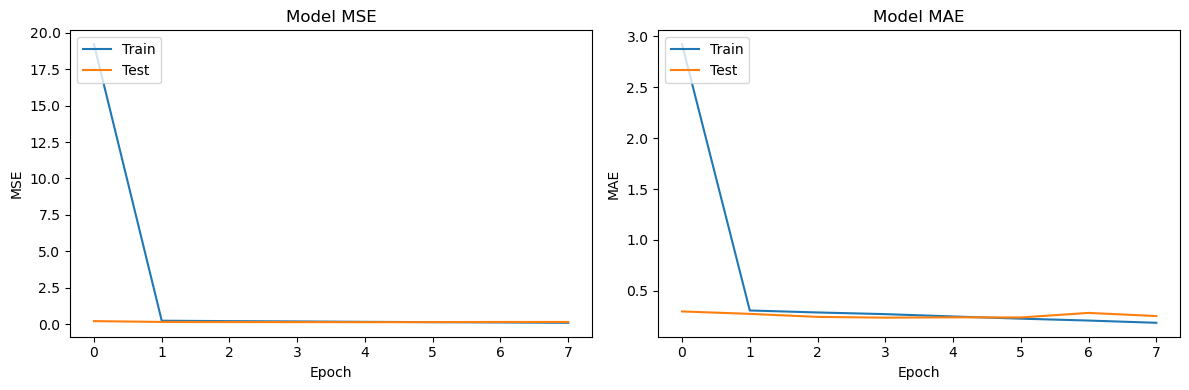

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [3]:
one_hot_cols = df.drop(columns=['combined', 'rating'])
X_train, X_test, y_train, y_test = train_test_split(df.drop('rating', axis=1), df['rating'], test_size=0.2)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize and fit the CountVectorizer
vectorizer = CountVectorizer()
X_train_combined = vectorizer.fit_transform(X_train['combined'])
X_test_combined = vectorizer.transform(X_test['combined'])

In [5]:
from scipy.sparse import hstack

X_train_final = hstack([X_train_combined, X_train.drop(columns=['combined'])])
X_test_final = hstack([X_test_combined, X_test.drop(columns=['combined'])])

In [7]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer to be used in cross validation
rmse_scorer = make_scorer(rmse, greater_is_better=False)

models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'AdaBoost Regression': AdaBoostRegressor()
}

In [ ]:
train_losses = {}
test_losses = {}

for model_name, model in models.items():
    train_loss = -cross_val_score(model, X_train_final, y_train, cv=5, scoring=rmse_scorer).mean()  # Use negative since the scorer returns negative values
    model.fit(X_train_final, y_train)
    test_preds = model.predict(X_test_final)
    test_loss = rmse(y_test, test_preds)
    train_losses[model_name] = train_loss
    test_losses[model_name] = test_loss

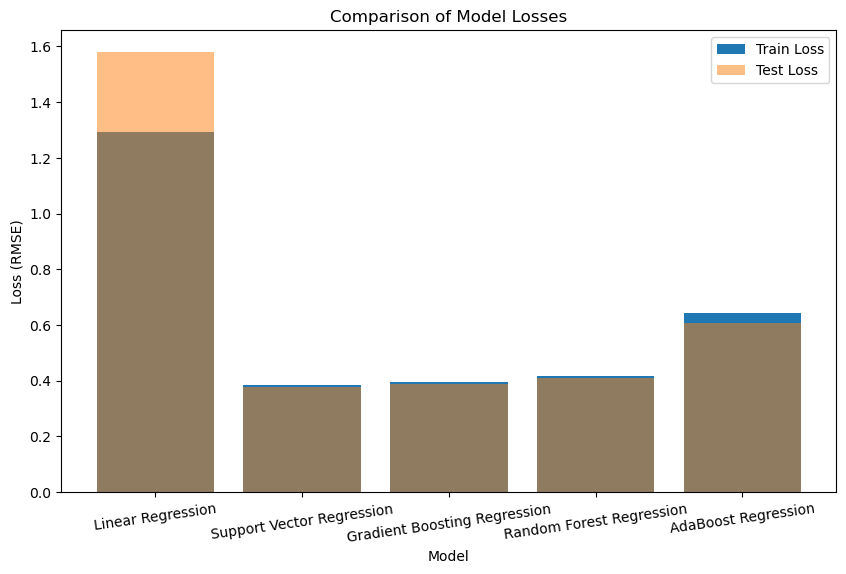

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(train_losses.keys(), train_losses.values(), label='Train Loss')
plt.bar(test_losses.keys(), test_losses.values(), label='Test Loss', alpha=0.5)
plt.xlabel('Model')
plt.ylabel('Loss (RMSE)')
plt.title('Comparison of Model Losses')
plt.xticks(rotation=8)
plt.legend()
plt.show()

In [40]:
models = {
    'Gradient Boosting': GradientBoostingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'AdaBoost': AdaBoostRegressor()
}

param_grids = {
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 1.0],
        'max_depth': [3, 4, 5]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 3, 4]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0]
    }
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer to be used in cross validation
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

best_params = {}
train_losses = {}
test_losses = {}

for model_name in models.keys():
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=5, scoring=rmse_scorer)
    grid_search.fit(X_train_final, y_train)

    # Get the best parameters and store them in the dictionary
    best_params[model_name] = grid_search.best_params_

    # Perform cross-validation with the best parameters
    model = models[model_name]
    model.set_params(**best_params[model_name])
    cv_results = cross_validate(model, X_train_final, y_train, cv=5, scoring=rmse_scorer, return_train_score=True)

    # Calculate losses (note: the RMSE values are negated to make them positive again)
    train_losses[model_name] = -cv_results['train_score'].mean()
    test_losses[model_name] = -cv_results['test_score'].mean()

In [42]:
for model_name, params in best_params.items():
    print(f"Best parameters for {model_name}: {params}")

Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best parameters for Random Forest: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 50}


In [8]:
from sklearn.metrics import make_scorer, r2_score

scorers = {
    'rmse': rmse_scorer,
    'r2': make_scorer(r2_score)
}

train_losses = {}
test_losses = {}
train_r2 = {}
test_r2 = {}

models = {
    'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=100),
    'Random Forest': RandomForestRegressor(max_depth=3, min_samples_split=2, n_estimators=100),
    'AdaBoost': AdaBoostRegressor(learning_rate=0.01, n_estimators=50)
}

train_losses = {}
test_losses = {}

for model_name, model in models.items():
    cv_results = cross_validate(model, X_train_final, y_train, cv=5, scoring=scorers, return_train_score=True)

    train_losses[model_name] = -cv_results['train_rmse'].mean()
    test_losses[model_name] = -cv_results['test_rmse'].mean()
    train_r2[model_name] = cv_results['train_r2'].mean()
    test_r2[model_name] = cv_results['test_r2'].mean()

c:\Users\gjaischool\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\gjaischool\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\gjaischool\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value fo

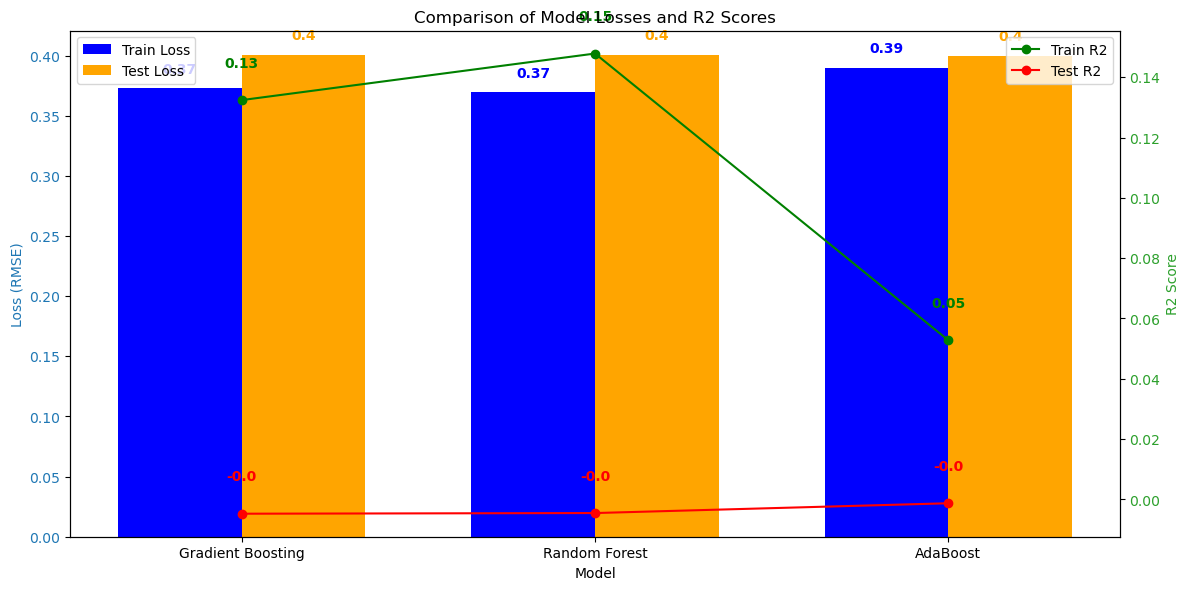

In [9]:
models = list(train_losses.keys())
train = list(train_losses.values())
test = list(test_losses.values())
train_r2_vals = list(train_r2.values())
test_r2_vals = list(test_r2.values())

n_models = len(models)
width = 0.35
ind = np.arange(n_models)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Model')
ax1.set_ylabel('Loss (RMSE)', color='tab:blue')
train_bars = ax1.bar(ind - width/2, train, width, label='Train Loss', color='blue')
test_bars = ax1.bar(ind + width/2, test, width, label='Test Loss', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(ind)
ax1.set_xticklabels(models)

# Use twinx() to create a second y-axis for the r2 score
ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:green')
ax2.plot(models, train_r2_vals, color='green', marker='o', label='Train R2')
ax2.plot(models, test_r2_vals, color='red', marker='o', label='Test R2')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Display RMSE values on the bars
for i, v in enumerate(train):
    ax1.text(i - width/2, v + 0.01, str(round(v, 2)), color='blue', fontweight='bold', ha='center', va='bottom')
for i, v in enumerate(test):
    ax1.text(i + width/2, v + 0.01, str(round(v, 2)), color='orange', fontweight='bold', ha='center', va='bottom')

# Display R2 values on the line plot
for i, v in enumerate(train_r2_vals):
    ax2.text(i, v + 0.01, str(round(v, 2)), color='green', fontweight='bold', ha='center', va='bottom')
for i, v in enumerate(test_r2_vals):
    ax2.text(i, v + 0.01, str(round(v, 2)), color='red', fontweight='bold', ha='center', va='bottom')

fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Comparison of Model Losses and R2 Scores')
plt.show()